In [1]:
import sys
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import RandomOverSampler
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GroupKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
import xgboost as xgb
from xgboost import plot_importance
from ydata_profiling import ProfileReport

In [2]:
df_train = pd.read_csv("train.csv").drop(["id"], axis=1)
df_test = pd.read_csv("test.csv")
test_IDs = df_test.id
df_test = df_test.drop("id", axis=1)
df_sample_sub = pd.read_csv("sample_submission.csv")
df_supp = pd.read_csv("cirrhosis.csv")[df_train.columns]

# Merge supplementary data
df_train = pd.concat(objs=[df_train, df_supp]).reset_index(drop=True)


In [3]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ
summary(df_train)

data shape: (8323, 19)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
N_Days,int64,0,0.00,495,41.00,"4,795.00","2,024.53","1,094.97",999,2574,3428
Drug,object,106,1.27,2,NaN,NaN,NaN,NaN,D-penicillamine,Placebo,Placebo
Age,int64,0,0.00,397,"9,598.00","28,650.00","18,381.19","3,686.83",21532,19237,13727
Sex,object,0,0.00,2,NaN,NaN,NaN,NaN,M,F,F
Ascites,object,106,1.27,2,NaN,NaN,NaN,NaN,N,N,N
Hepatomegaly,object,106,1.27,2,NaN,NaN,NaN,NaN,N,N,Y
Spiders,object,106,1.27,2,NaN,NaN,NaN,NaN,N,N,Y
Edema,object,0,0.00,3,NaN,NaN,NaN,NaN,N,N,Y
Bilirubin,float64,0,0.00,117,0.30,28.00,2.63,3.85,2.30,0.90,3.30
Cholesterol,float64,134,1.61,227,120.00,"1,775.00",351.22,196.78,316.00,364.00,299.00


In [4]:
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [5]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    cat_cols.remove("Status")
    return cat_cols, cat_but_car, num_cols
    

cat_cols, cat_but_car, num_cols = grab_col_names(df_train)

Observations: 8181
Variables: 19
cat_cols: 8
num_cols: 11
cat_but_car: 0
num_but_cat: 1


Text(0.5, 1.0, 'Distribution of Status')

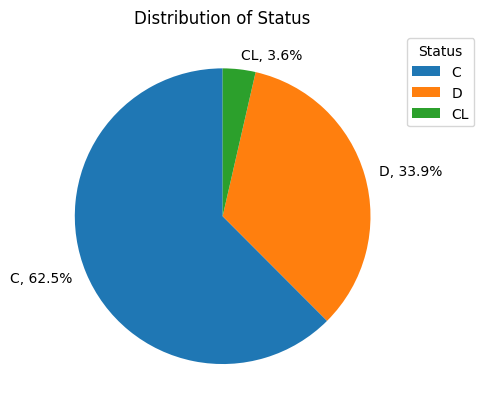

In [6]:
status_counts = df_train["Status"].value_counts()
labels = status_counts.index
sizes = status_counts.values
percentages = 100.*sizes/sizes.sum()

plt.pie(sizes, labels=[f"{l}, {s:.1f}%" for l, s in zip(labels, percentages)], startangle=90)
plt.gca().set_aspect("equal")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1), labels=labels, title="Status")
plt.title(f"Distribution of Status")

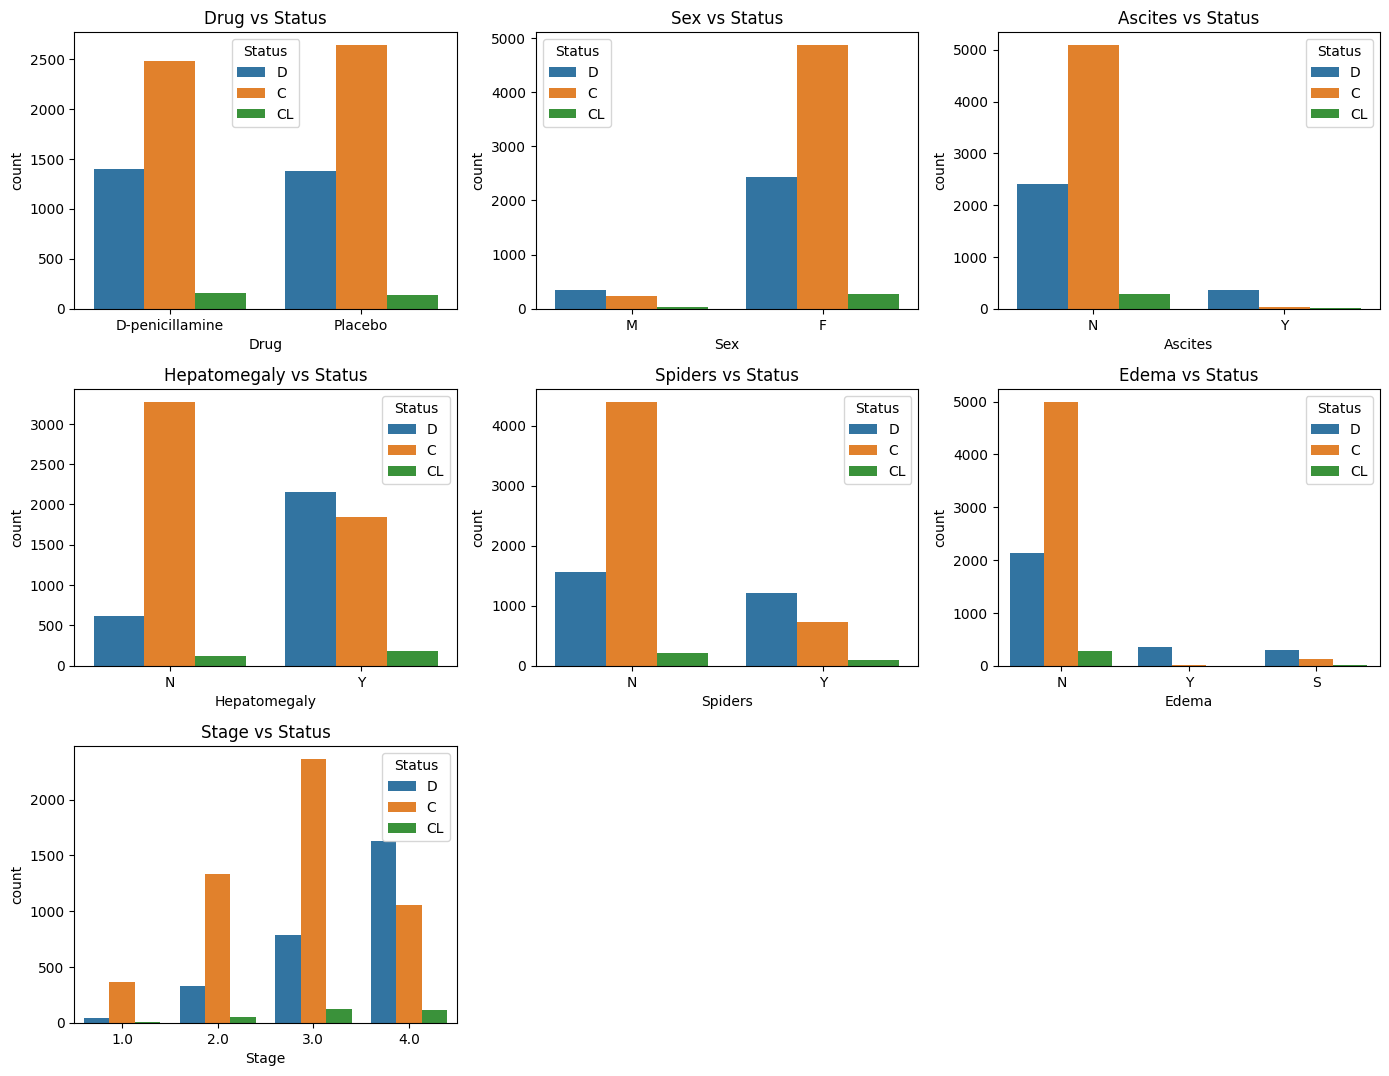

In [7]:
def cat_target_summary_with_cat(dataframe, target, categorical_col):
    plt.figure(figsize=(14, len(categorical_col) * 2))
    for i, col in enumerate(categorical_col):
        plt.subplot(len(categorical_col) // 2 + 1, 3, i + 1)
        sns.countplot(x=col, hue=target, data=dataframe)
        plt.title(f"{col} vs {target}")
        plt.tight_layout()
cat_target_summary_with_cat(df_train,"Status",cat_cols)

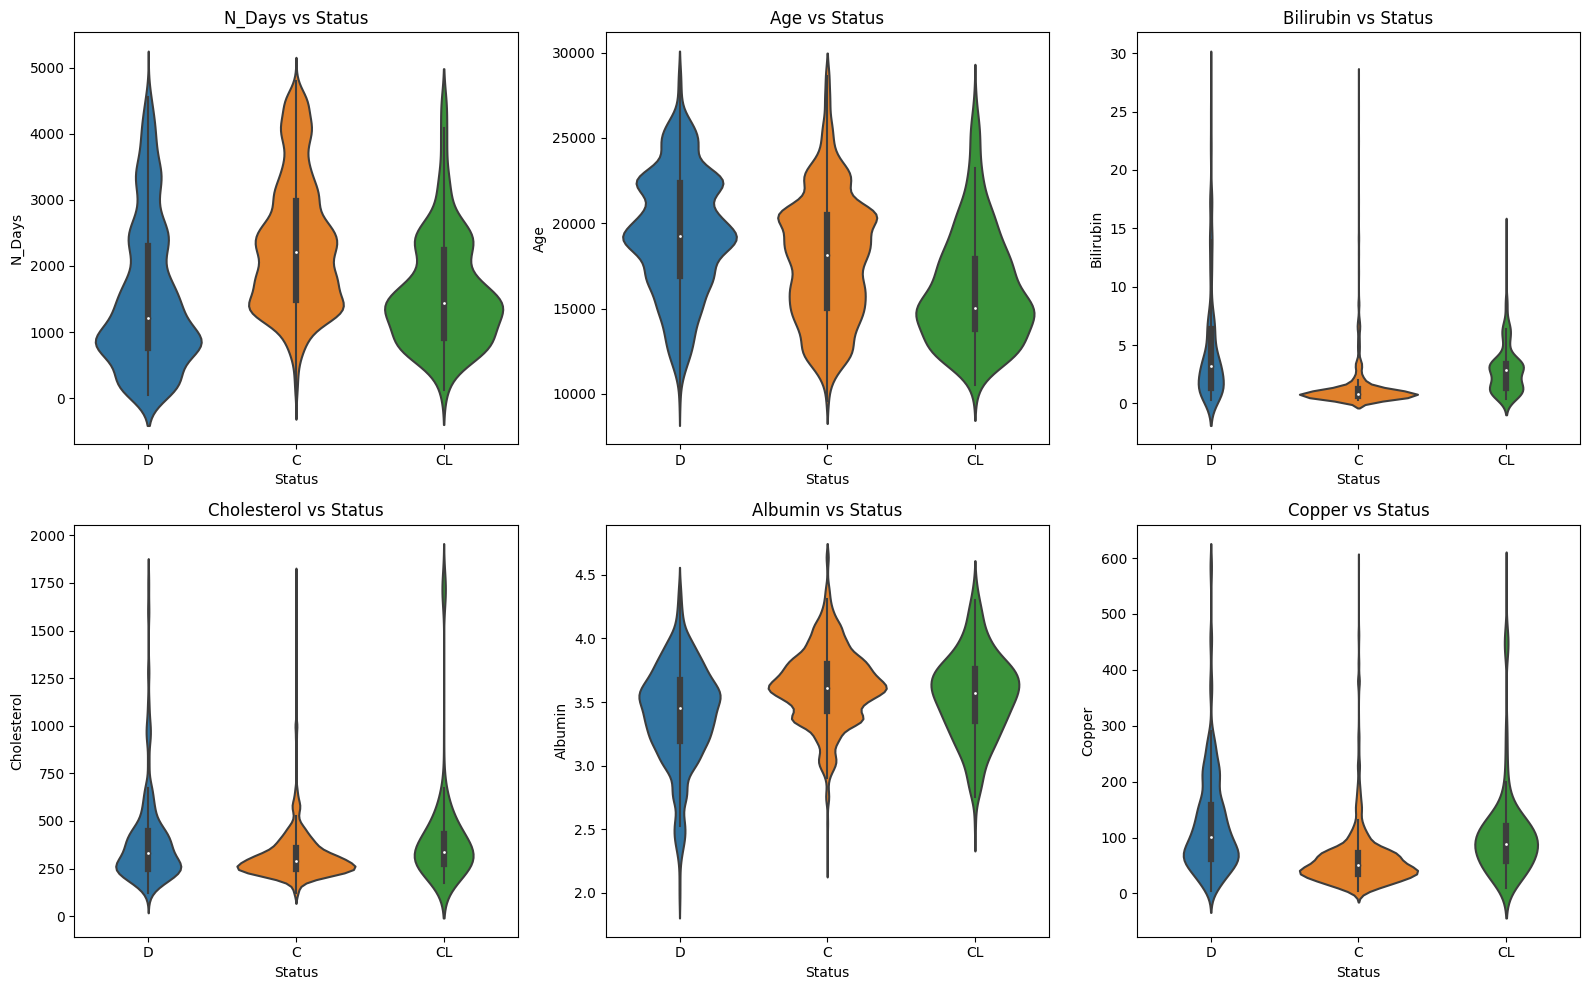

In [8]:
def cat_target_summary_with_num(dataframe, target, num_col):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    for i, ax in enumerate(axes.flatten()):
        sns.violinplot(x=target, y=num_col[i], data=dataframe, ax=ax)
        # Set x ticks to be the original labels (inverse transform)
        ax.set_title(f"{num_col[i]} vs {target}")
    plt.tight_layout()
    plt.show()
cat_target_summary_with_num(df_train,"Status",num_cols)

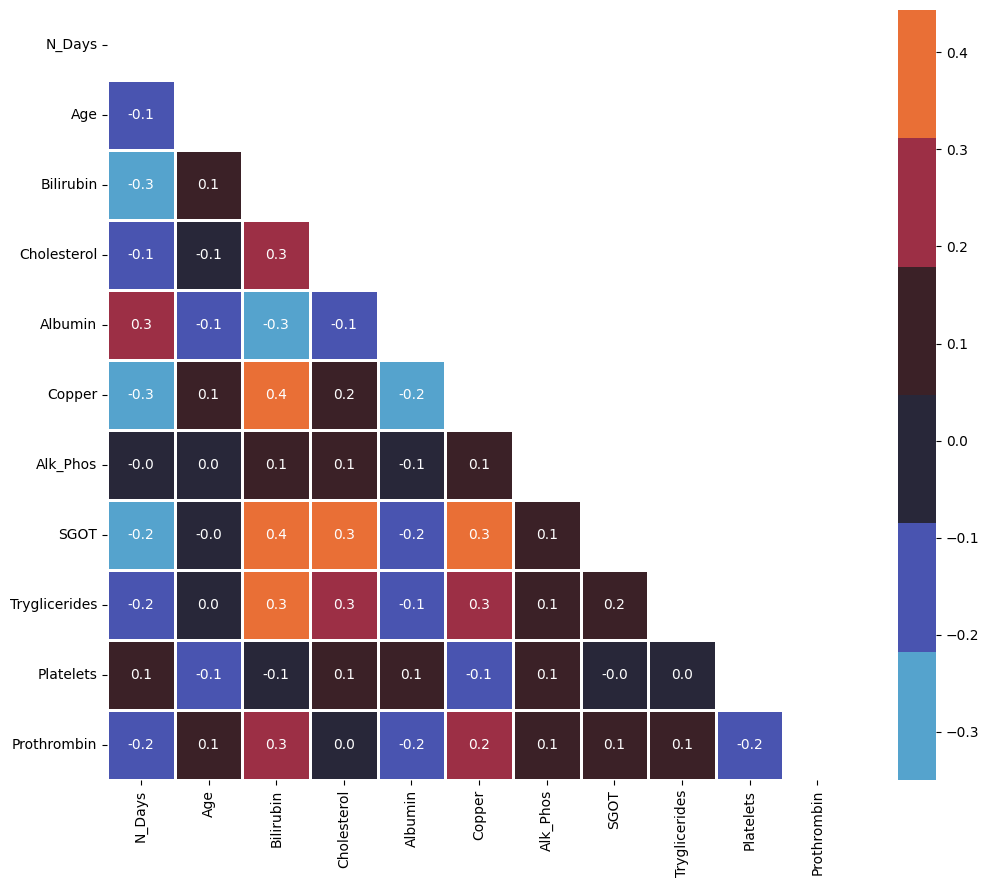

In [9]:
plt.figure(figsize=(12,10))
corr=df_train[num_cols].corr(numeric_only=True)
mask= np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, fmt=".1f", linewidths=1, mask=mask, cmap=sns.color_palette("icefire"));

In [10]:
df_train_mod = df_train.copy()
df_test_mod = df_test.copy()
label_encoder = LabelEncoder()
df_train_mod["Status"] = label_encoder.fit_transform(df_train_mod["Status"])

In [11]:
encoders = {
    'Drug': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, categories=[['Placebo', 'D-penicillamine']]),
    'Sex': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Ascites': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Hepatomegaly': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Spiders': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    'Edema': OneHotEncoder(),
    'Stage': OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
}

In [12]:
for feat, enc in encoders.items():
    if isinstance(enc, OrdinalEncoder):
        df_train_mod[feat] = enc.fit_transform(df_train_mod[[feat]]).astype('int32')
        df_test_mod[feat] = enc.transform(df_test_mod[[feat]]).astype('int32')
    if isinstance(enc, OneHotEncoder):
        # Transform and get new column names
        new_cols = enc.fit_transform(df_train_mod[[feat]]).toarray().astype('int8')
        col_names = enc.get_feature_names_out()
        
        # Add new columns to the dataframe
        df_train_mod[col_names] = new_cols
        df_train_mod.drop(feat, axis=1, inplace=True)  # Drop original column
        
        # Repeat for the test set
        new_cols_test = enc.transform(df_test_mod[[feat]]).toarray().astype('int8')
        df_test_mod[col_names] = new_cols_test
        df_test_mod.drop(feat, axis=1, inplace=True)

In [13]:
df_train_mod['Diagnosis_Date'] = df_train_mod['Age'] - df_train_mod['N_Days']
df_train_mod['Age_Years'] = round(df_train_mod['Age'] / 365.25).astype("int16")
df_train_mod['Age_Group'] = pd.cut(df_train_mod['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
df_train_mod['Bilirubin_Albumin'] = df_train_mod['Bilirubin'] * df_train_mod['Albumin']
df_train_mod['Drug_Effectiveness'] = df_train_mod['Drug'] * df_train_mod['Bilirubin']
df_train_mod['Diag_Year'] = (df_train_mod['N_Days'] / 365).astype(int)
liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
df_train_mod['Liver_Function_Index'] = df_train_mod[liver_columns].mean(axis=1)
df_train_mod['Diag_Month'] = ((df_train_mod['N_Days'] % 365) / 30).astype(int)
df_train_mod['Risk_Score'] = df_train_mod['Bilirubin'] + df_train_mod['Albumin'] - df_train_mod['Alk_Phos']


In [14]:
scaler = StandardScaler()
num_feats = num_cols + ['Diagnosis_Date', 'Age_Years', 'Bilirubin_Albumin', 'Drug_Effectiveness', 
                                       'Liver_Function_Index', 'Risk_Score', 'Diag_Year', 'Diag_Month']

scaler.fit(df_train_mod[num_feats])

df_train_mod[num_feats] = scaler.transform(df_train_mod[num_feats])


In [15]:
df_test_mod['Diagnosis_Date'] = df_test_mod['Age'] - df_test_mod['N_Days']
df_test_mod['Age_Years'] = round(df_test_mod['Age'] / 365.25).astype("int16")
df_test_mod['Age_Group'] = pd.cut(df_test_mod['Age_Years'], bins=[19, 29, 49, 64, 99], labels = [0, 1, 2, 3]).astype('int16')
df_test_mod['Bilirubin_Albumin'] = df_test_mod['Bilirubin'] * df_test_mod['Albumin']
df_test_mod['Drug_Effectiveness'] = df_test_mod['Drug'] * df_test_mod['Bilirubin']
df_test_mod['Diag_Year'] = (df_test_mod['N_Days'] / 365).astype(int)
liver_columns = ['Bilirubin', 'Albumin', 'Alk_Phos', 'SGOT']
df_test_mod['Liver_Function_Index'] = df_test_mod[liver_columns].mean(axis=1)
df_test_mod['Diag_Month'] = ((df_test_mod['N_Days'] % 365) / 30).astype(int)
df_test_mod['Risk_Score'] = df_test_mod['Bilirubin'] + df_test_mod['Albumin'] - df_test_mod['Alk_Phos']
scaler.fit(df_test_mod[num_feats])

df_test_mod[num_feats] = scaler.transform(df_test_mod[num_feats])

In [16]:
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit

# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False
for col in num_cols:
    print(col, check_outlier(df_train_mod, col))

N_Days False
Age False
Bilirubin True
Cholesterol True
Albumin False
Copper True
Alk_Phos True
SGOT True
Tryglicerides True
Platelets False
Prothrombin True


In [17]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df_train_mod,col)

In [18]:
cat_cols, cat_but_car, num_cols = grab_col_names(df_train_mod)

Observations: 8181
Variables: 30
cat_cols: 11
num_cols: 19
cat_but_car: 0
num_but_cat: 11


In [19]:
X, y = df_train_mod.drop('Status', axis = 1), df_train_mod['Status']


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 2610, stratify = y)
skf = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 1, random_state = 2610)

In [21]:
from lightgbm import LGBMClassifier


lgbm_params = {'objective': 'multiclass', 
               'max_depth': 9, 'min_child_samples': 14, 
               'learning_rate': 0.034869481921747415, 
               'n_estimators': 274, 'min_child_weight': 9, 
               'subsample': 0.7717873512945741, 
               'colsample_bytree': 0.1702910221565107, 
               'reg_alpha': 0.10626128775335533, 
               'reg_lambda': 0.624196407787772, 
               'random_state': 42}
lgbm_model = LGBMClassifier(**lgbm_params)
lgbm_model.fit(X, y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3110
[LightGBM] [Info] Number of data points in the train set: 8181, number of used features: 29
[LightGBM] [Info] Start training from score -0.470224
[LightGBM] [Info] Start training from score -3.329397
[LightGBM] [Info] Start training from score -1.080803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

LGBMClassifier(colsample_bytree=0.1702910221565107,
               learning_rate=0.034869481921747415, max_depth=9,
               min_child_samples=14, min_child_weight=9, n_estimators=274,
               objective='multiclass', random_state=42,
               reg_alpha=0.10626128775335533, reg_lambda=0.624196407787772,
               subsample=0.7717873512945741)

In [22]:
preds = lgbm_model.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [23]:
y_pred_probs = lgbm_model.predict_proba(X_test)
print('Log loss for lgbm_model: ', log_loss(y_test, y_pred_probs))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Log loss for lgbm_model:  0.2584905245941454


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


print("Accuracy:", accuracy_score(y_test, preds)) 
print("Precision:", precision_score(y_test, preds, average="weighted")) 
print('Recall:', recall_score(y_test, preds, average="weighted")) 

Accuracy: 0.9079804560260586
Precision: 0.9083213093407865
Recall: 0.9079804560260586


In [27]:
y_test_hat = lgbm_model.predict_proba(df_test_mod)
assert y_test_hat.shape == (df_test.shape[0], 3)
submission_labels = ["Status_C", "Status_CL", "Status_D"]

sub = pd.DataFrame(
    {"id": test_IDs, **dict(zip(submission_labels, y_test_hat.T))}
)
sub.head()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,id,Status_C,Status_CL,Status_D
0,7905,0.50,0.03,0.47
1,7906,0.62,0.24,0.14
2,7907,0.04,0.01,0.95
3,7908,0.96,0.00,0.03
4,7909,0.87,0.05,0.07


In [28]:
sub.to_csv('submission.csv', index=False)
